In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# for handling and parsing email files
import email
import os
import re
import nltk

In [3]:
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from collections import Counter

In [4]:
# modeling
from sklearn.pipeline import Pipeline
# base class cung cấp các phương thức chung và tiện ích 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, confusion_matrix, f1_score
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB

In [5]:
# load ham and spam files (filename)
ham_fnames = [name for name in sorted(os.listdir("main_ham"))]
spam_fnames = [name for name in sorted(os.listdir("main_spam"))]

In [6]:
hl, sl = len(ham_fnames), len(spam_fnames)

print("Number of ham files:", hl)
print("Number of spam files:", sl)
print("Spam to Ham ratio:", sl/hl)
print("Spam percentage: ", (sl / (sl + hl)) * 100, "%")

Number of ham files: 6951
Number of spam files: 2397
Spam to Ham ratio: 0.3448424687095382
Spam percentage:  25.641848523748394 %


In [7]:
# Đọc tệp tin email, phân tích nội dung
def parse_email(fname, spam=False):
    directory = "main_spam" if spam else "main_ham"
    with open(os.path.join(directory, fname), "rb") as fp:
        return email.parser.BytesParser().parse(fp)
        
ham_emails = [parse_email(name) for name in ham_fnames]
spam_emails = [parse_email(name, spam=True) for name in spam_fnames]

In [8]:
# total
len(ham_emails + spam_emails)

9348

In [9]:
test_email = ham_emails[0]
print(test_email)

Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: yyyy@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id 7106643C34
	for <jm@localhost>; Wed, 21 Aug 2002 08:33:03 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Wed, 21 Aug 2002 13:33:03 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7LCXvZ24654 for
    <jm-exmh@jmason.org>; Wed, 21 Aug 2002 13:33:57 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id F12A13EA25; Wed, 21 Aug 2002
    08:34:00 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp.spamassassin.taint.org (int-mx1.corp.spamassassin.taint.org
    [172.16.52.254

In [10]:
hamPlusSpamData = ham_emails + spam_emails
labels = ["ham"]*len(ham_emails) + ["spam"]*len(spam_emails)
raw_df = pd.DataFrame({"label": labels, "email": hamPlusSpamData})

In [11]:
raw_df.sample(5)

,label,email
1683,ham,"[Return-Path, Delivered-To, Received, Received..."
6418,ham,"[Return-Path, Delivered-To, Received, Received..."
8383,spam,"[Return-Path, Delivered-To, Received, Received..."
4861,ham,"[Return-Path, Delivered-To, Received, Received..."
7631,spam,"[Return-Path, Delivery-Date, Return-Path, Rece..."


In [12]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9348 entries, 0 to 9347
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9348 non-null   object
 1   email   9348 non-null   object
dtypes: object(2)
memory usage: 146.2+ KB


In [13]:
# missing values
raw_df.isnull().sum()

label    0
email    0
dtype: int64

In [14]:
# check for duplicate values
raw_df.duplicated().sum()

0

In [15]:
raw_df.shape

(9348, 2)

In [16]:
print(raw_df.label.value_counts())

ham     6951
spam    2397
Name: label, dtype: int64


<AxesSubplot: >

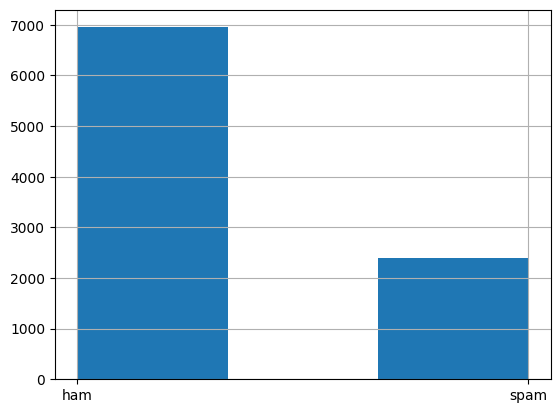

In [17]:
# get an overview of the data

raw_df.label.hist(bins=3)

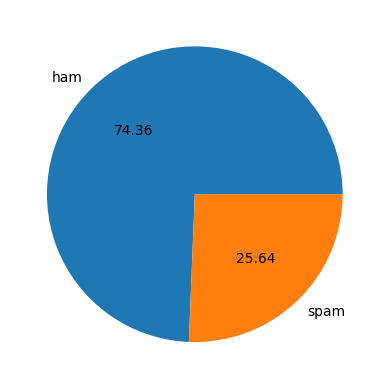

In [18]:
import matplotlib.pyplot as plt
plt.pie(raw_df['label'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [19]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PCC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PCC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
print("Header fields: ", test_email.keys())
print("Field values: ", test_email.values())
print("Email content: ", test_email.get_payload())

Header fields:  ['Return-Path', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'Received', 'Received', 'From', 'To', 'Cc', 'Subject', 'In-Reply-To', 'References', 'MIME-Version', 'Content-Type', 'Message-Id', 'X-Loop', 'Sender', 'Errors-To', 'X-Beenthere', 'X-Mailman-Version', 'Precedence', 'List-Help', 'List-Post', 'List-Subscribe', 'List-Id', 'List-Unsubscribe', 'List-Archive', 'Date']
Field values:  ['<exmh-workers-admin@spamassassin.taint.org>', 'yyyy@localhost.netnoteinc.com', 'from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id 7106643C34\n\tfor <jm@localhost>; Wed, 21 Aug 2002 08:33:03 -0400 (EDT)', 'from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor jm@localhost (single-drop); Wed, 21 Aug 2002 13:33:03 +0100 (IST)', 'from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by\n    dogma.slashnull.org (8

In [21]:
print("Email content: ", spam_emails[3].get_payload())

Email content:  1) Fight The Risk of Cancer!
http://www.adclick.ws/p.cfm?o=315&s=pk007

2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days
http://www.adclick.ws/p.cfm?o=249&s=pk007

3) Get the Child Support You Deserve - Free Legal Advice
http://www.adclick.ws/p.cfm?o=245&s=pk002

4) Join the Web's Fastest Growing Singles Community
http://www.adclick.ws/p.cfm?o=259&s=pk007

5) Start Your Private Photo Album Online!
http://www.adclick.ws/p.cfm?o=283&s=pk007

Have a Wonderful Day,
Offer Manager
PrizeMama













If you wish to leave this list please use the link below.
http://www.qves.com/trim/?ilug@linux.ie%7C17%7C114258


-- 
Irish Linux Users' Group: ilug@linux.ie
http://www.linux.ie/mailman/listinfo/ilug for (un)subscription information.
List maintainer: listmaster@linux.ie




In [22]:
test_email.get_content_type()

'text/plain'

In [23]:
multi_email = None

for mail in ham_emails:
    if mail.is_multipart():
        multi_email = mail
        break

# Payload will be list of email.message.Message
print(multi_email.get_payload())

[<email.message.Message object at 0x000001C327928670>, <email.message.Message object at 0x000001C327D8CFA0>]


In [24]:
# Nested get payload
print(multi_email.get_payload()[1].get_payload())
print(multi_email.items())

-----BEGIN PGP SIGNATURE-----
Version: GnuPG v1.0.6 (GNU/Linux)
Comment: Exmh version 2.2_20000822 06/23/2000

iD8DBQE9Y66GK9b4h5R0IUIRAsIYAJ4zEJm2B6tIQDD4MQu7LbapzZpAsgCcCJtl
bDfb8a2wKMtAgWylF44XooU=
=WC8I
-----END PGP SIGNATURE-----

[('Return-Path', '<exmh-workers-admin@spamassassin.taint.org>'), ('Delivered-To', 'yyyy@localhost.netnoteinc.com'), ('Received', 'from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id DE7E443C32\n\tfor <jm@localhost>; Wed, 21 Aug 2002 11:18:34 -0400 (EDT)'), ('Received', 'from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor jm@localhost (single-drop); Wed, 21 Aug 2002 16:18:34 +0100 (IST)'), ('Received', 'from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7LFFwZ30827 for\n    <jm-exmh@jmason.org>; Wed, 21 Aug 2002 16:16:07 +0100'), ('Received', 'from listman.spamassassin.taint.org (localhost.localdo

In [25]:
# function to get the structure of email (multipart or single)

def get_structure(email) -> str:
    # can be a non leaf
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join(
            get_structure(message)
            for message in payload
        ))
    else:
        return email.get_content_type()

In [26]:
get_structure(test_email)

'text/plain'

In [27]:
get_structure(multi_email)

'multipart(text/plain, application/pgp-signature)'

In [28]:
# Function to count all the structures
def email_structure_counter(emails):
    structs = Counter()
    for mail in emails:
        mail_struct = get_structure(mail)
        structs[mail_struct] += 1
    return structs

ham_structs = email_structure_counter(ham_emails)
spam_structs = email_structure_counter(spam_emails)

In [29]:
def draw_wordcloud(structs): 
    wordcloud = WordCloud(width=1600, height=800, random_state=3301)
    wordcloud.generate_from_frequencies(frequencies=structs)

    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

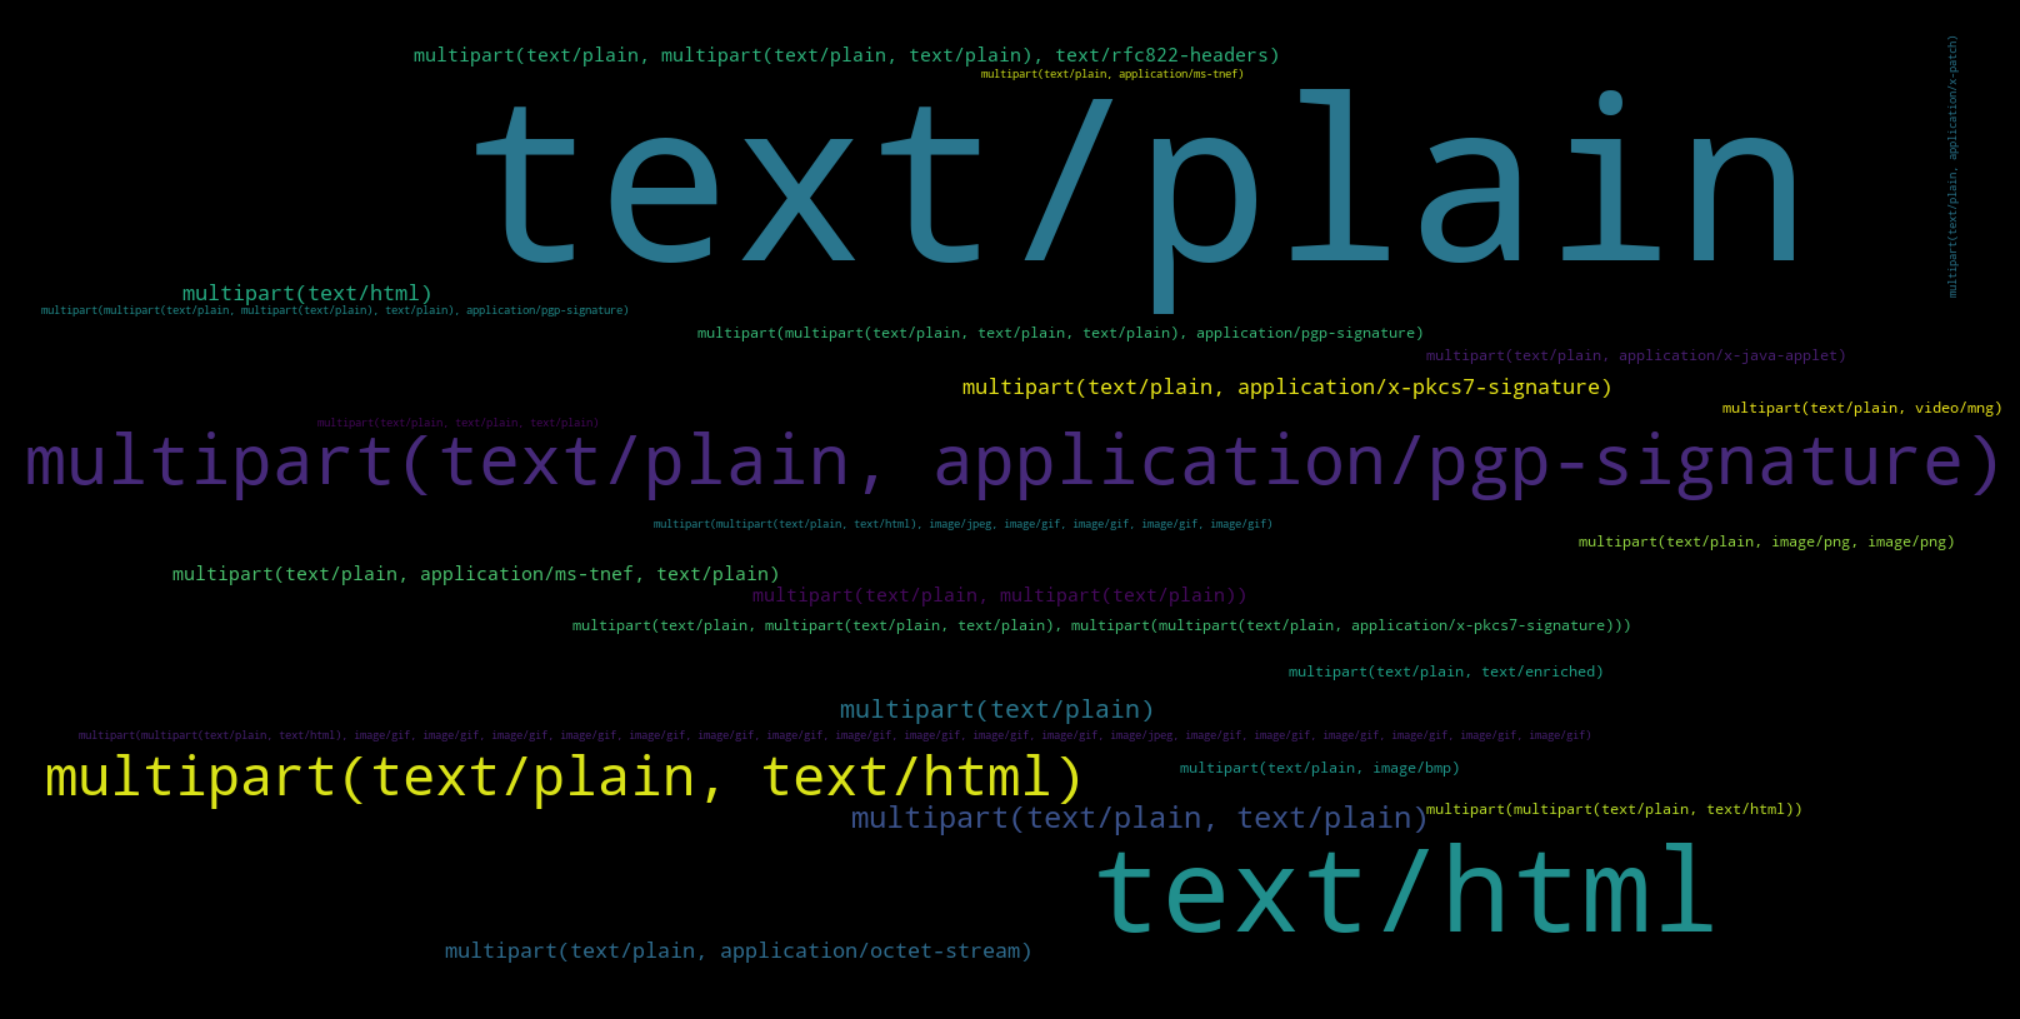

[('text/plain', 6371),
 ('text/html', 240),
 ('multipart(text/plain, application/pgp-signature)', 173),
 ('multipart(text/plain, text/html)', 109),
 ('multipart(text/plain, text/plain)', 9),
 ('multipart(text/plain)', 6),
 ('multipart(text/plain, application/x-pkcs7-signature)', 4),
 ('multipart(text/html)', 4),
 ('multipart(text/plain, application/octet-stream)', 4),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 3),
 ('multipart(text/plain, multipart(text/plain))', 3),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  3),
 ('multipart(text/plain, image/bmp)', 2),
 ('multipart(text/plain, text/enriched)', 2),
 ('multipart(multipart(text/plain, text/html))', 2),
 ('multipart(text/plain, image/png, image/png)', 2),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  2),
 ('multipart(text/plain, video/mng)', 2),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain,

In [30]:
draw_wordcloud(ham_structs)
ham_structs.most_common()

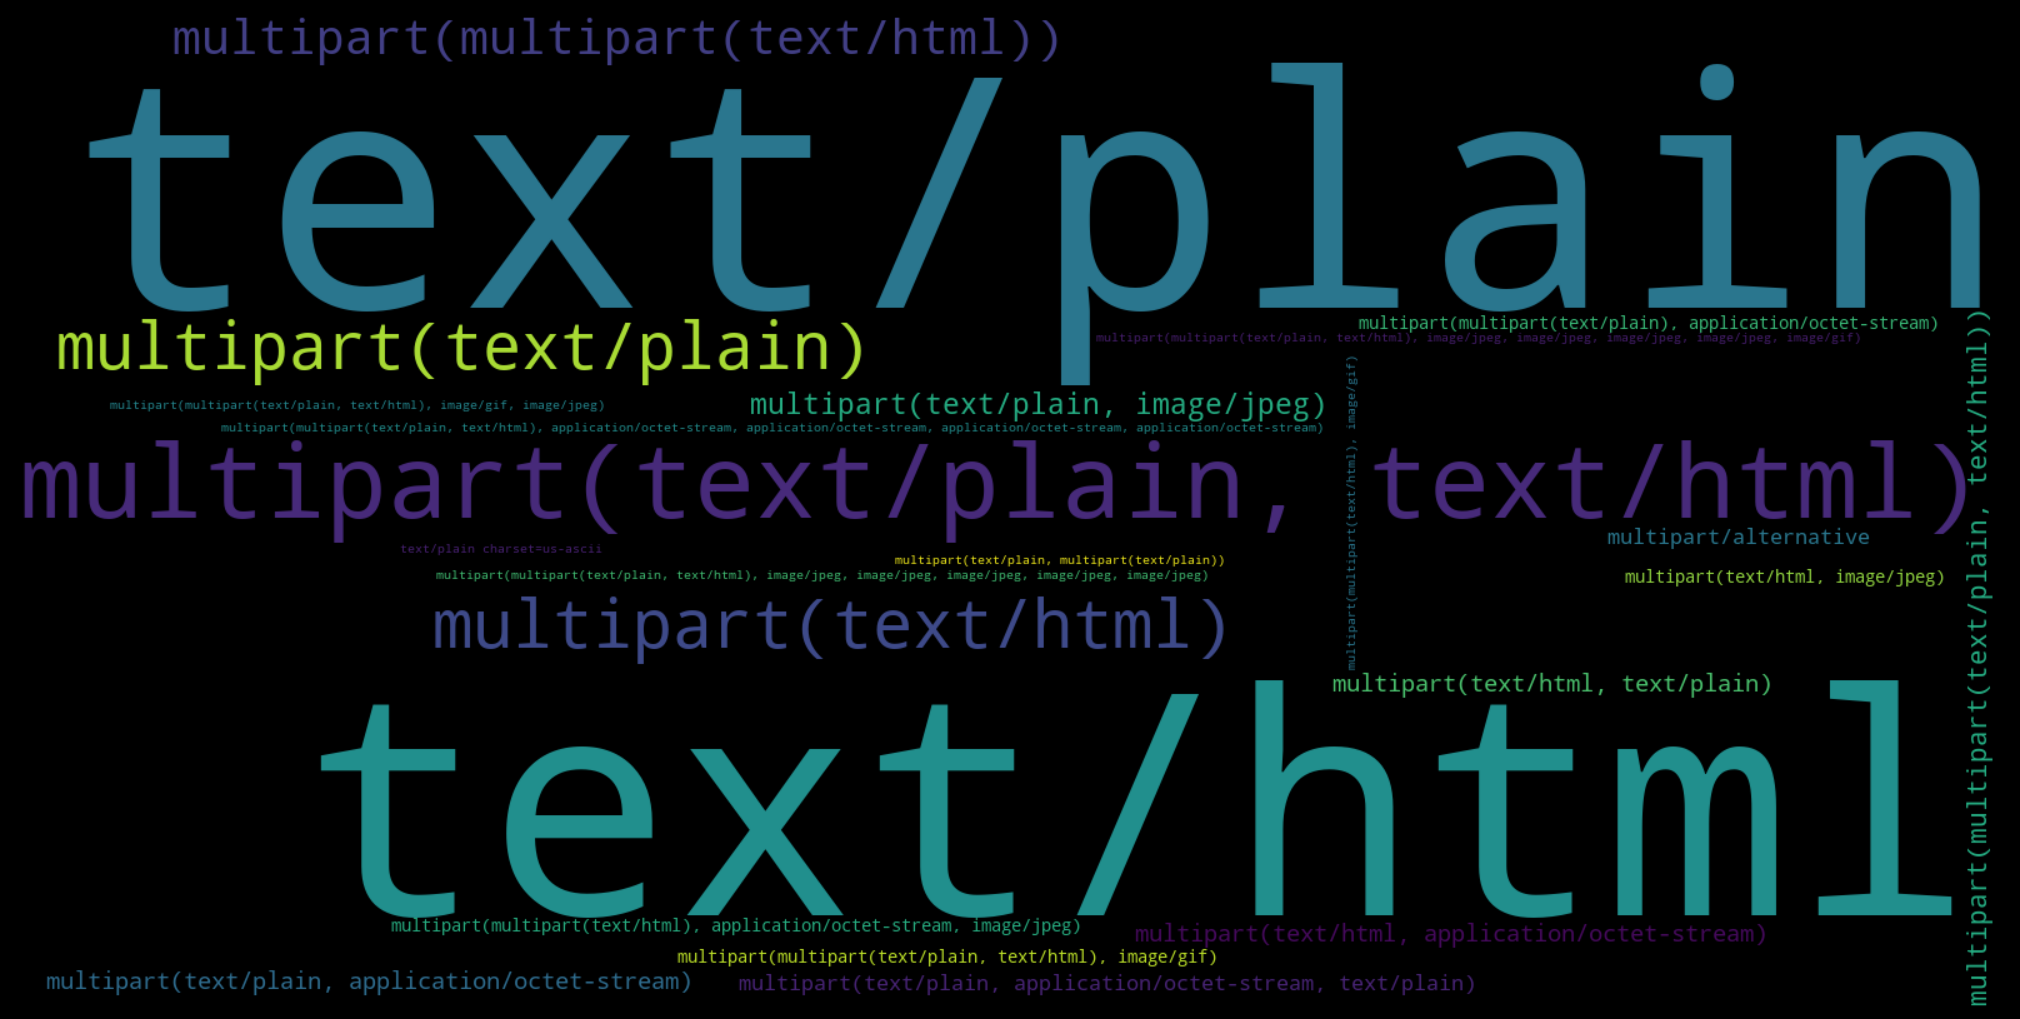

[('text/plain', 1037),
 ('text/html', 953),
 ('multipart(text/plain, text/html)', 204),
 ('multipart(text/html)', 68),
 ('multipart(text/plain)', 63),
 ('multipart(multipart(text/html))', 28),
 ('multipart(text/plain, image/jpeg)', 6),
 ('multipart(multipart(text/plain, text/html))', 5),
 ('multipart(text/plain, application/octet-stream)', 4),
 ('multipart(text/html, text/plain)', 4),
 ('multipart(text/html, application/octet-stream)', 4),
 ('multipart(text/plain, application/octet-stream, text/plain)', 3),
 ('multipart/alternative', 3),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 2),
 ('multipart(multipart(text/plain, text/html), image/gif)', 2),
 ('multipart(text/html, image/jpeg)', 2),
 ('multipart(multipart(text/plain), application/octet-stream)', 2),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(multipart(text/plain, text/html), image/jpeg, image/jpeg, image/jpeg, image/jpeg, image/jpeg)',
  1),
 ('multipart(multipart(text/plain,

In [31]:
draw_wordcloud(spam_structs)
spam_structs.most_common()

In [32]:
html_email = None

for email in spam_emails:
    if get_structure(email) == 'text/html':
        html_email = email
        break

print(html_email.get_payload())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<HTML><HEAD>
<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=
ype>
<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>
<BODY><!-- Inserted by Calypso -->
<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=
ules=3Dnone 
style=3D"COLOR: black; DISPLAY: none" width=3D"100%">
  <TBODY>
  <TR>
    <TD colSpan=3D3>
      <HR color=3Dblack noShade SIZE=3D1>
    </TD></TR></TD></TR>
  <TR>
    <TD colSpan=3D3>
      <HR color=3Dblack noShade SIZE=3D1>
    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=
 --><FONT 
color=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=
/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 
face=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">
<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=
0000 
face=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">
<CENTER>Why

In [33]:
def html_to_text(email) -> str:
    try:
        soup = BeautifulSoup(email.get_payload(), "html.parser")
        plain = soup.text.replace("=\n", "")
        plain = re.sub(r"\s+", " ", plain)
        return plain.strip()
    except:
        return "nothing"

In [34]:
print(html_to_text(html_email))

</TR> Save up to 70% on Life Insurance. Why Spend More Than You Have To? Life Quote Savings Ensuring your family's financial security is very important. Life Quote Savings makes buying life insurance simple and affordable. We Provide FREE Access to The Very Best Companies and The Lowest Rates. Life Quote Savings is FAST, EASY and SAVES you money! Let us help you get started with the best values in the country on new coverage. You can SAVE hundreds or even thousands of dollars by requesting a FREE quote from Lifequote Savings. Our service will take you less than 5 minutes to complete. Shop and compare. SAVE up to 70% on all types of Life insurance! Click Here For Your Free Quote! Protecting your family is the best investment you'll ever make! If you are in receipt of this email in error and/or wish to be removed from our list, PLEASE CLICK HERE AND TYPE REMOVE. If you reside in any state which prohibits e-mail solicitations for insurance, please disregard this email.


In [35]:
# General purpose function to convert an email to plain text
def email_to_text(email):
    text_content = ""
    for part in email.walk():
        part_content_type = part.get_content_type()
        if part_content_type not in ['text/plain', 'text/html']:
            continue
        if part_content_type == 'text/plain':
            text_content += part.get_payload()
        else:
            text_content += html_to_text(part)
    return text_content

print("Ham email in plain text:\n", email_to_text(ham_emails[0]))

Ham email in plain text:
     Date:        Tue, 20 Aug 2002 17:27:47 -0500
    From:        Chris Garrigues <cwg-exmh@DeepEddy.Com>
    Message-ID:  <1029882468.3116.TMDA@deepeddy.vircio.com>


  | I'm hoping that all people with no additional sequences will notice are
  | purely cosmetic changes.

Well, first, when exmh (the latest one with your changes) starts, I get...

can't read "flist(totalcount,unseen)": no such element in array
    while executing
"if {$flist(totalcount,$mhProfile(unseen-sequence)) > 0} {
	FlagInner spool iconspool labelup
    } else {
	FlagInner down icondown labeldown
    }"
    (procedure "Flag_MsgSeen" line 3)
    invoked from within
"Flag_MsgSeen"
    (procedure "MsgSeen" line 8)
    invoked from within
"MsgSeen $msgid"
    (procedure "MsgShow" line 12)
    invoked from within
"MsgShow $msgid"
    (procedure "MsgChange" line 17)
    invoked from within
"MsgChange 4862 show"
    invoked from within
"time [list MsgChange $msgid $show"
    (procedure "Msg_Cha

In [36]:
print("Spam email in plain text:\n", email_to_text(spam_emails[1]))

Spam email in plain text:
 </TR> Save up to 70% on Life Insurance. Why Spend More Than You Have To? Life Quote Savings Ensuring your family's financial security is very important. Life Quote Savings makes buying life insurance simple and affordable. We Provide FREE Access to The Very Best Companies and The Lowest Rates. Life Quote Savings is FAST, EASY and SAVES you money! Let us help you get started with the best values in the country on new coverage. You can SAVE hundreds or even thousands of dollars by requesting a FREE quote from Lifequote Savings. Our service will take you less than 5 minutes to complete. Shop and compare. SAVE up to 70% on all types of Life insurance! Click Here For Your Free Quote! Protecting your family is the best investment you'll ever make! If you are in receipt of this email in error and/or wish to be removed from our list, PLEASE CLICK HERE AND TYPE REMOVE. If you reside in any state which prohibits e-mail solicitations for insurance, please disregard this

In [37]:
content_ham_emails = [email_to_text(email) for email in ham_emails]
subject_ham_emails = [email.get('Subject') for email in ham_emails]
content_spam_emails = [email_to_text(email) for email in spam_emails]
subject_spam_emails = [email.get('Subject') for email in spam_emails]

In [38]:
content_all_emails = content_ham_emails + content_spam_emails
subject_all_emails = subject_ham_emails + subject_spam_emails
labels = ["ham"]*len(content_ham_emails) + ["spam"]*len(content_spam_emails)
df = pd.DataFrame({"label": labels, "subject": subject_all_emails, "content": content_all_emails})
# Xáo trộn thứ tự các email trong Dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9348 entries, 0 to 9347
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    9348 non-null   object
 1   subject  9341 non-null   object
 2   content  9348 non-null   object
dtypes: object(3)
memory usage: 219.2+ KB


In [40]:
df.sample(5)

,label,subject,content
2546,spam,One of a kind Money maker! Try it for free!,CONSANTLY being bombarded by so-called FREE ...
7460,ham,Re: [SAtalk] Lotus Notes users?,On Saturday 07 September 2002 23:22 CET Daniel...
21,spam,Time Share,Interested in Renting or Selling your\nTimesha...
1112,ham,Yahoo Finance RSS Beta,URL: http://jeremy.zawodny.com/blog/archives/0...
5027,ham,Market Can't Find Its Bottom With Both Hands,"To view this newsletter in full-color, visit:\..."


In [41]:
df.isnull().sum()

label      0
subject    7
content    0
dtype: int64

In [42]:
df['subject'].fillna('Unknown', inplace=True)

In [43]:
df['subject'] = df['subject'].astype(str)

In [44]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])
df.head()

,label,subject,content
0,0,A&L Daily to be auctioned in bankruptcy,URL: http://boingboing.net/#85534171\nDate: No...
1,0,"Wired: ""Stronger ties between ISPs and file-tr...",URL: http://scriptingnews.userland.com/backiss...
2,1,It's just too small HLOY,"A man endowed with a 7-8"" hammer is simply bet..."
3,0,liberal defnitions,Depends on how much over spending vs. how much...
4,0,RE: [ILUG] Newbie seeks advice - Suse 7.2,hehe sorry but if you hit caps lock twice the ...


In [45]:
df['num_characters'] = df['content'].apply(len)
df.head()

,label,subject,content,num_characters
0,0,A&L Daily to be auctioned in bankruptcy,URL: http://boingboing.net/#85534171\nDate: No...,349
1,0,"Wired: ""Stronger ties between ISPs and file-tr...",URL: http://scriptingnews.userland.com/backiss...,270
2,1,It's just too small HLOY,"A man endowed with a 7-8"" hammer is simply bet...",266
3,0,liberal defnitions,Depends on how much over spending vs. how much...,1460
4,0,RE: [ILUG] Newbie seeks advice - Suse 7.2,hehe sorry but if you hit caps lock twice the ...,1957


In [46]:
# num of words
df['num_words'] = df['content'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,label,subject,content,num_characters,num_words
0,0,A&L Daily to be auctioned in bankruptcy,URL: http://boingboing.net/#85534171\nDate: No...,349,75
1,0,"Wired: ""Stronger ties between ISPs and file-tr...",URL: http://scriptingnews.userland.com/backiss...,270,42
2,1,It's just too small HLOY,"A man endowed with a 7-8"" hammer is simply bet...",266,59
3,0,liberal defnitions,Depends on how much over spending vs. how much...,1460,287
4,0,RE: [ILUG] Newbie seeks advice - Suse 7.2,hehe sorry but if you hit caps lock twice the ...,1957,405


In [47]:
df['num_sentences'] = df['content'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,label,subject,content,num_characters,num_words,num_sentences
0,0,A&L Daily to be auctioned in bankruptcy,URL: http://boingboing.net/#85534171\nDate: No...,349,75,3
1,0,"Wired: ""Stronger ties between ISPs and file-tr...",URL: http://scriptingnews.userland.com/backiss...,270,42,2
2,1,It's just too small HLOY,"A man endowed with a 7-8"" hammer is simply bet...",266,59,4
3,0,liberal defnitions,Depends on how much over spending vs. how much...,1460,287,12
4,0,RE: [ILUG] Newbie seeks advice - Suse 7.2,hehe sorry but if you hit caps lock twice the ...,1957,405,19


In [48]:
#mean: độ lệch chuẩn: đo mức độ phân tán
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,9348.000000,9348.000000,9348.000000
mean,2084.135430,387.977963,15.250428
std,5403.706236,879.452682,29.763083
min,0.000000,0.000000,0.000000
25%,565.750000,103.000000,5.000000
50%,1037.000000,197.000000,8.000000
75%,1900.000000,368.000000,15.000000
max,194824.000000,18579.000000,809.000000


In [49]:
# ham email
df[df['label'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,6951.000000,6951.000000,6951.000000
mean,1895.517336,364.565386,14.132643
std,5133.911235,830.896372,28.677155
min,47.000000,3.000000,1.000000
25%,522.500000,98.000000,4.000000
50%,976.000000,193.000000,8.000000
75%,1711.000000,347.000000,14.000000
max,194824.000000,18579.000000,809.000000


In [50]:
#spam email
df[df['label'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,2397.000000,2397.000000,2397.000000
mean,2631.104297,455.871506,18.491865
std,6087.389045,1004.217851,32.498562
min,0.000000,0.000000,0.000000
25%,700.000000,116.000000,5.000000
50%,1204.000000,207.000000,10.000000
75%,2533.000000,446.000000,18.000000
max,126335.000000,18447.000000,408.000000


(-3000.0, 30000.0)

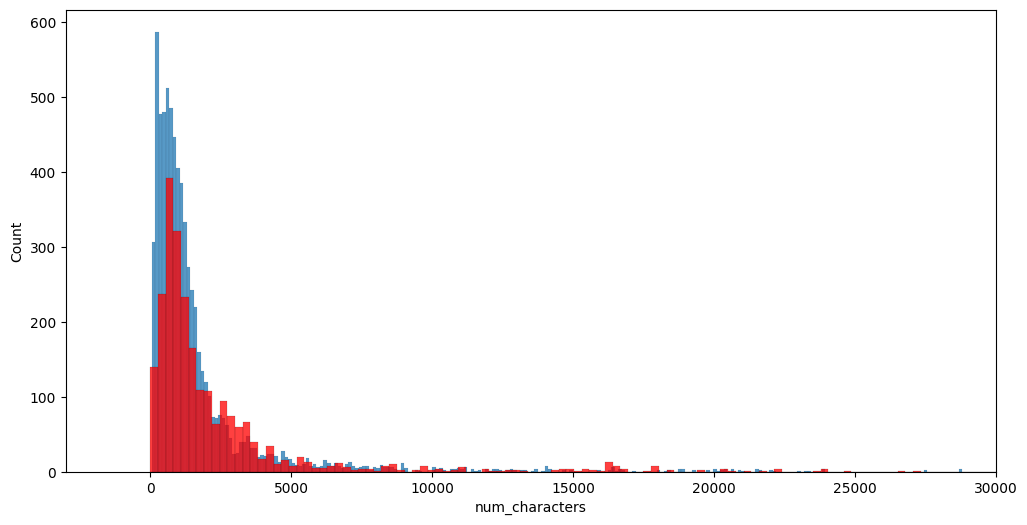

In [51]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.histplot(df[df['label'] == 0]['num_characters'])
sns.histplot(df[df['label'] == 1]['num_characters'],color='red')
plt.xlim(-3000, 30000) # Giới hạn kích thước trục x để quan sát biểu đồ rõ ràng hơn

(-500.0, 7000.0)

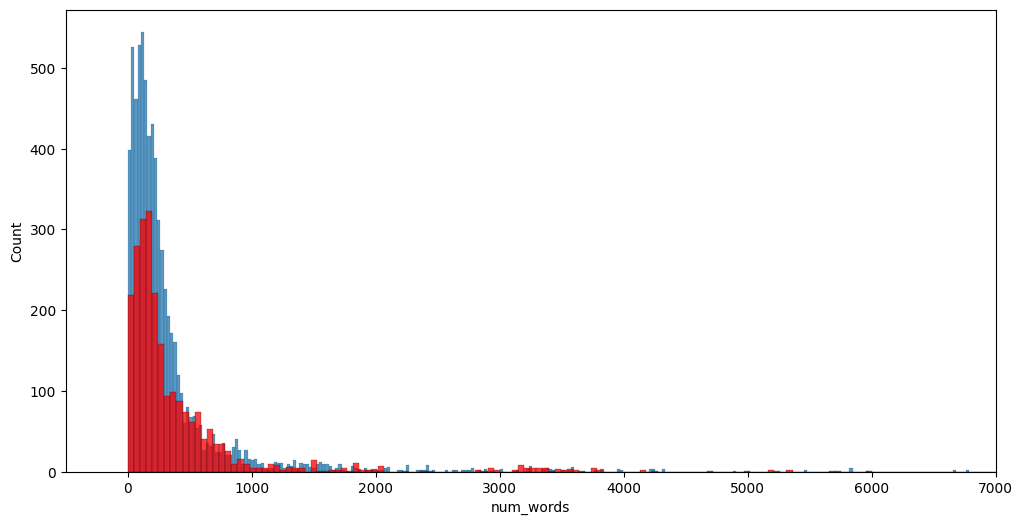

In [52]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['label'] == 0]['num_words'])
sns.histplot(df[df['label'] == 1]['num_words'],color='red')
plt.xlim(-500, 7000) # Giới hạn kích thước trục x để quan sát biểu đồ rõ ràng hơn

(-10.0, 200.0)

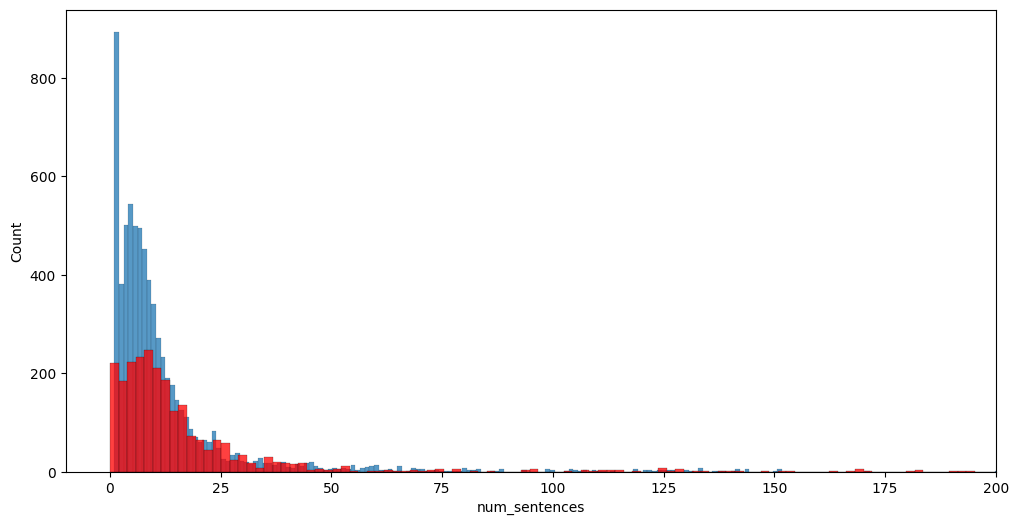

In [53]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['label'] == 0]['num_sentences'])
sns.histplot(df[df['label'] == 1]['num_sentences'],color='red')
plt.xlim(-10, 200) # Giới hạn kích thước trục x để quan sát biểu đồ rõ ràng hơn

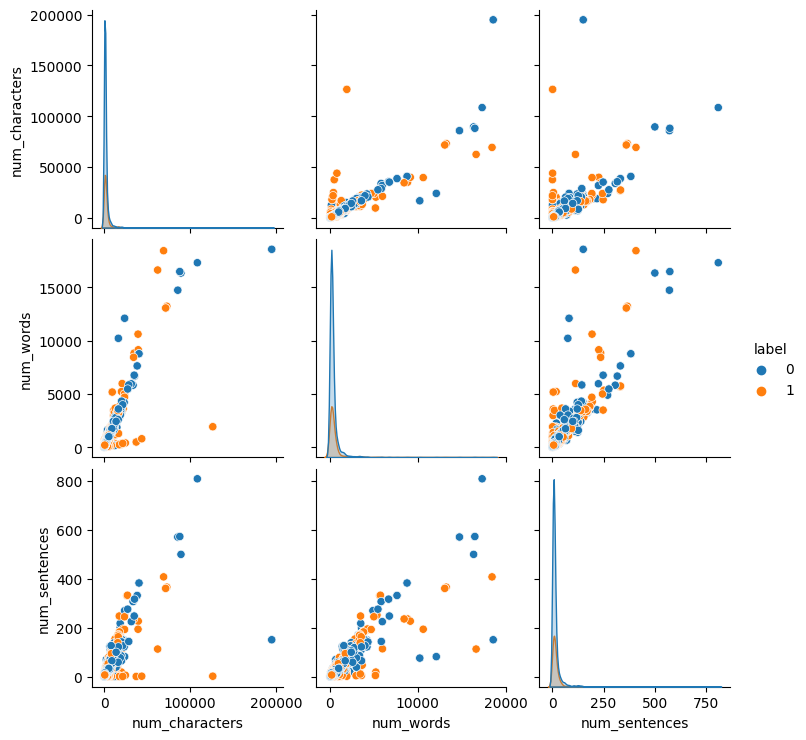

In [54]:
sns.pairplot(df,hue='label')

C:\Users\PCC\AppData\Local\Temp\ipykernel_15012\2829558919.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<AxesSubplot: >

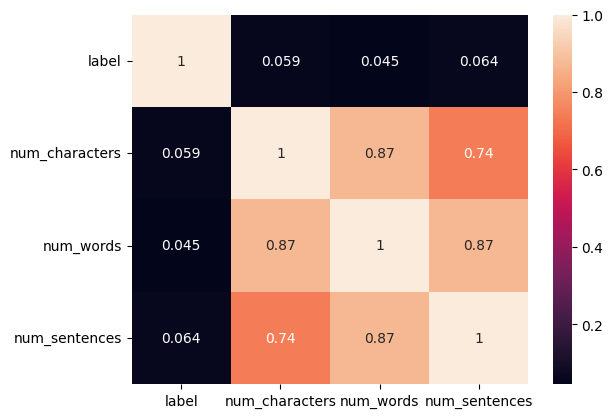

In [55]:
# Hệ số tương quan đo lường mức độ tương quan tuyến tính giữa hai biến
sns.heatmap(df.corr(),annot=True)

In [56]:
text = "Hello, today I am going to London for performing and dancing"
stemmer = nltk.PorterStemmer()

for word in text.split():
    stemmed_word = stemmer.stem(word)
    print(stemmed_word, end=" ")

hello, today i am go to london for perform and danc 

In [57]:
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [58]:
def transform_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = nltk.word_tokenize(text)
    
    y = []
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [59]:
print(content_spam_emails[0])

Greetings!

You are receiving this letter because you have expressed an interest in 
receiving information about online business opportunities. If this is 
erroneous then please accept my most sincere apology. This is a one-time 
mailing, so no removal is necessary.

If you've been burned, betrayed, and back-stabbed by multi-level marketing, 
MLM, then please read this letter. It could be the most important one that 
has ever landed in your Inbox.

MULTI-LEVEL MARKETING IS A HUGE MISTAKE FOR MOST PEOPLE

MLM has failed to deliver on its promises for the past 50 years. The pursuit 
of the "MLM Dream" has cost hundreds of thousands of people their friends, 
their fortunes and their sacred honor. The fact is that MLM is fatally 
flawed, meaning that it CANNOT work for most people.

The companies and the few who earn the big money in MLM are NOT going to 
tell you the real story. FINALLY, there is someone who has the courage to 
cut through the hype and lies and tell the TRUTH about MLM.



In [60]:
transform_text(content_spam_emails[0])

'greet receiv letter express interest receiv inform onlin busi opportun erron pleas accept sincer apolog onetim mail remov necessari youv burn betray backstab multilevel market mlm pleas read letter could import one ever land inbox multilevel market huge mistak peopl mlm fail deliv promis past year pursuit mlm dream cost hundr thousand peopl friend fortun sacr honor fact mlm fatal flaw mean work peopl compani earn big money mlm go tell real stori final someon courag cut hype lie tell truth mlm here good news altern mlm work work big havent yet abandon dream need see earn kind incom youv dream easier think permiss id like send brief letter tell mlm doesnt work peopl introduc someth new refresh youll wonder havent heard promis unwant follow sale pitch one call email address use send inform period receiv free lifechang inform simpli click repli type send info subject box hit send ill get inform within hour look word mlm wall shame inbox cordial siddhi ps someon recent sent letter eyeopen 

In [61]:
transform_text(subject_spam_emails[3])

'ilug guarante lose lb day'

In [62]:
df['transformed_subject'] = df['subject'].apply(transform_text)
df.head()

,label,subject,content,num_characters,num_words,num_sentences,transformed_subject
0,0,A&L Daily to be auctioned in bankruptcy,URL: http://boingboing.net/#85534171\nDate: No...,349,75,3,al daili auction bankruptci
1,0,"Wired: ""Stronger ties between ISPs and file-tr...",URL: http://scriptingnews.userland.com/backiss...,270,42,2,wire stronger tie isp filetrad compani could b...
2,1,It's just too small HLOY,"A man endowed with a 7-8"" hammer is simply bet...",266,59,4,small hloy
3,0,liberal defnitions,Depends on how much over spending vs. how much...,1460,287,12,liber defnit
4,0,RE: [ILUG] Newbie seeks advice - Suse 7.2,hehe sorry but if you hit caps lock twice the ...,1957,405,19,ilug newbi seek advic suse


In [63]:
df['transformed_content'] = df['content'].apply(transform_text)
df.head()

,label,subject,content,num_characters,num_words,num_sentences,transformed_subject,transformed_content
0,0,A&L Daily to be auctioned in bankruptcy,URL: http://boingboing.net/#85534171\nDate: No...,349,75,3,al daili auction bankruptci,url httpboingboingnet date suppli art letter d...
1,0,"Wired: ""Stronger ties between ISPs and file-tr...",URL: http://scriptingnews.userland.com/backiss...,270,42,2,wire stronger tie isp filetrad compani could b...,url httpscriptingnewsuserlandcombackissueswhen...
2,1,It's just too small HLOY,"A man endowed with a 7-8"" hammer is simply bet...",266,59,4,small hloy,man endow hammer simpli better equip man hamme...
3,0,liberal defnitions,Depends on how much over spending vs. how much...,1460,287,12,liber defnit,depend much spend vs much type regul biggest p...
4,0,RE: [ILUG] Newbie seeks advice - Suse 7.2,hehe sorry but if you hit caps lock twice the ...,1957,405,19,ilug newbi seek advic suse,hehe sorri hit cap lock twice comput crash the...


In [64]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

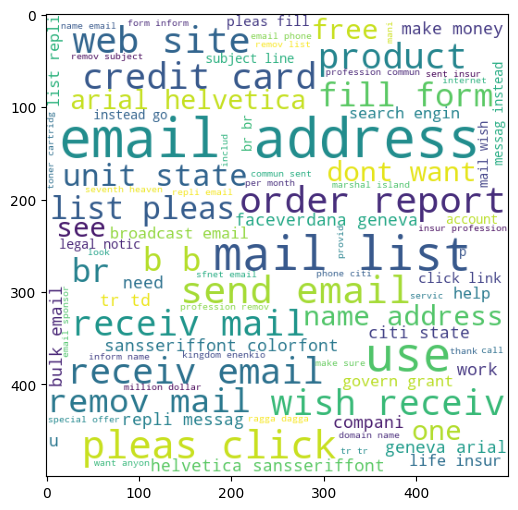

In [65]:
#WordCloud spam_emails_content
spam_wc = wc.generate(df[df['label'] == 1]['transformed_content'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

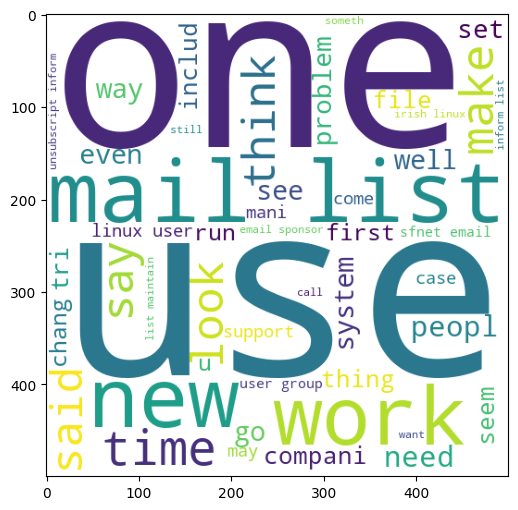

In [66]:
#WordCloud ham_emails_content
ham_wc = wc.generate(df[df['label'] == 0]['transformed_content'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

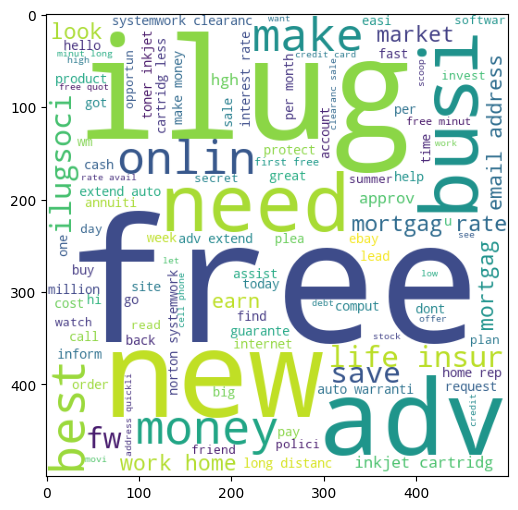

In [67]:
#WordCloud spam_emails_subject
spam_wc = wc.generate(df[df['label'] == 1]['transformed_subject'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

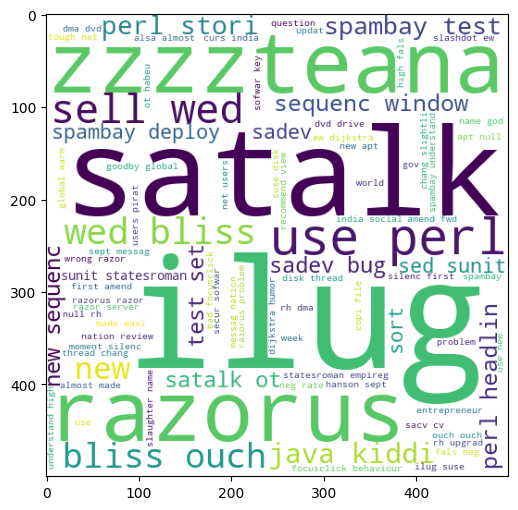

In [68]:
#WordCloud ham_emails_subject
spam_wc = wc.generate(df[df['label'] == 0]['transformed_subject'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

In [69]:
spam_corpus_content = []
for msg in df[df['label'] == 1]['transformed_content'].tolist():
    for word in msg.split():
        spam_corpus_content.append(word)
len(spam_corpus_content)

458078

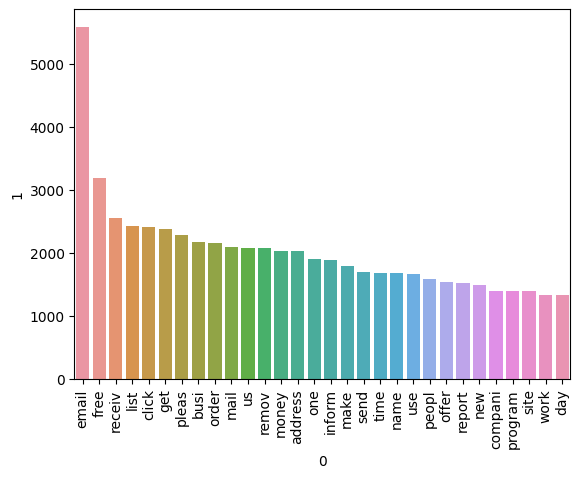

In [70]:
from collections import Counter
sns.barplot(x=pd.DataFrame(Counter(spam_corpus_content).most_common(30))[0],y=pd.DataFrame(Counter(spam_corpus_content).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [71]:
ham_corpus_content = []
for msg in df[df['label'] == 0]['transformed_content'].tolist():
    for word in msg.split():
        ham_corpus_content.append(word)
len(ham_corpus_content)

1069390

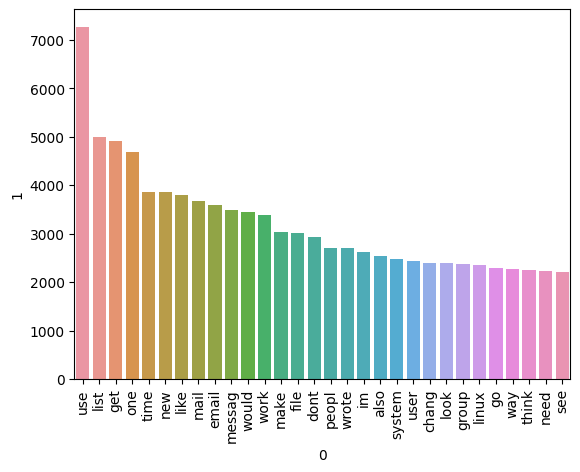

In [72]:
sns.barplot(x=pd.DataFrame(Counter(ham_corpus_content).most_common(30))[0],y=pd.DataFrame(Counter(ham_corpus_content).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [73]:
spam_corpus_subject = []
for msg in df[df['label'] == 1]['transformed_subject'].tolist():
    for word in msg.split():
        spam_corpus_subject.append(word)
len(spam_corpus_subject)

9382

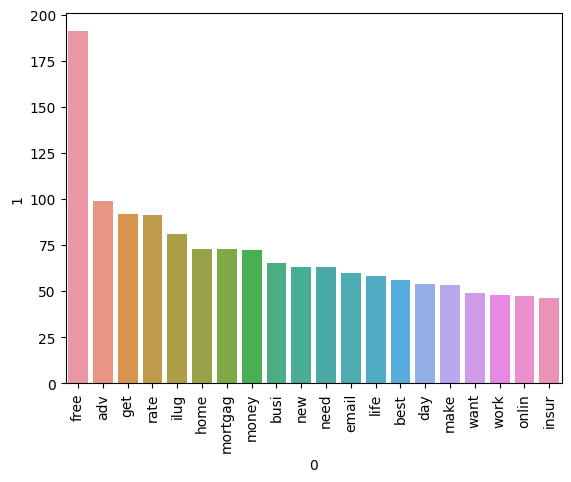

In [74]:
sns.barplot(x=pd.DataFrame(Counter(spam_corpus_subject).most_common(20))[0],y=pd.DataFrame(Counter(spam_corpus_subject).most_common(20))[1])
plt.xticks(rotation='vertical')
plt.show()

In [75]:
ham_corpus_subject = []
for msg in df[df['label'] == 0]['transformed_subject'].tolist():
    for word in msg.split():
        ham_corpus_subject.append(word)
len(ham_corpus_subject)

27731

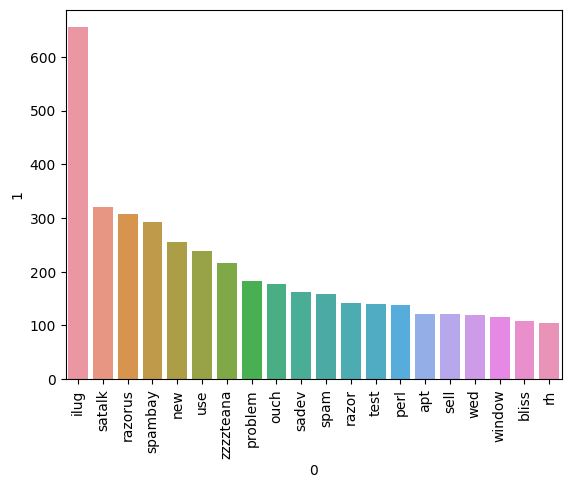

In [76]:
sns.barplot(x=pd.DataFrame(Counter(ham_corpus_subject).most_common(20))[0],y=pd.DataFrame(Counter(ham_corpus_subject).most_common(20))[1])
plt.xticks(rotation='vertical')
plt.show()

In [77]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=3000)

In [78]:
X_bow_content = cv.fit_transform(df['transformed_content']).toarray()
X_bow_content.shape

(9348, 3000)

In [79]:
X_bow_subject = cv.fit_transform(df['transformed_subject']).toarray()
X_bow_subject.shape

(9348, 3000)

In [80]:
X_bow = np.hstack((X_bow_subject, X_bow_content))
X_bow.shape

(9348, 6000)

In [81]:
y_bow = df['label'].values

In [82]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y_bow, test_size=0.2, shuffle=True, random_state=2, stratify=y_bow)
print("Training set size: ", X_train_bow.shape, y_train_bow.shape)
print("Testing set size: ", X_test_bow.shape, y_test_bow.shape)

Training set size:  (7478, 6000) (7478,)
Testing set size:  (1870, 6000) (1870,)


In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=3000)

In [84]:
X_tfidf_content = tfidf.fit_transform(df['transformed_content']).toarray()
X_tfidf_content.shape

(9348, 3000)

In [85]:
X_tfidf_subject = tfidf.fit_transform(df['transformed_subject']).toarray()
X_tfidf_subject.shape

(9348, 3000)

In [86]:
X_tfidf = np.hstack((X_tfidf_subject, X_tfidf_content))
X_tfidf.shape

(9348, 6000)

In [87]:
y_tfidf = df['label'].values

In [88]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.2, shuffle=True, random_state=2, stratify=y_tfidf)
print("Training set size: ", X_train_tfidf.shape, y_train_tfidf.shape)
print("Testing set size: ", X_test_tfidf.shape, y_test_tfidf.shape)

Training set size:  (7478, 6000) (7478,)
Testing set size:  (1870, 6000) (1870,)


In [101]:
mnb = MultinomialNB()
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores =[]
clfs = {
    'NB + BoW': mnb,
    'NB + TF-IDF': mnb, 
}

In [102]:
def comp_esti(esti, Xtr, Xte, ytr, yte):
    esti.fit(Xtr, ytr)
    y_pred = esti.predict(Xte)
    accuracy = accuracy_score(yte, y_pred)
    precision = precision_score(yte, y_pred, pos_label=1)
    recall = recall_score(yte, y_pred, pos_label=1)
    f1Score = f1_score(yte, y_pred, pos_label=1)
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1Score)
    
    print(f"{esti} Accuracy score: ", accuracy)
    print(f"\n{esti} Classification report:\n", classification_report(yte, y_pred, digits=6))
    
    # confusion matrix
    cf_mat = confusion_matrix(yte, y_pred)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(data=cf_mat, annot=True, fmt='d', ax=ax)
    plt.show()

MultinomialNB() Accuracy score:  0.9759358288770054

MultinomialNB() Classification report:
               precision    recall  f1-score   support

           0   0.975938  0.992086  0.983946      1390
           1   0.975930  0.929167  0.951974       480

    accuracy                       0.975936      1870
   macro avg   0.975934  0.960626  0.967960      1870
weighted avg   0.975936  0.975936  0.975739      1870



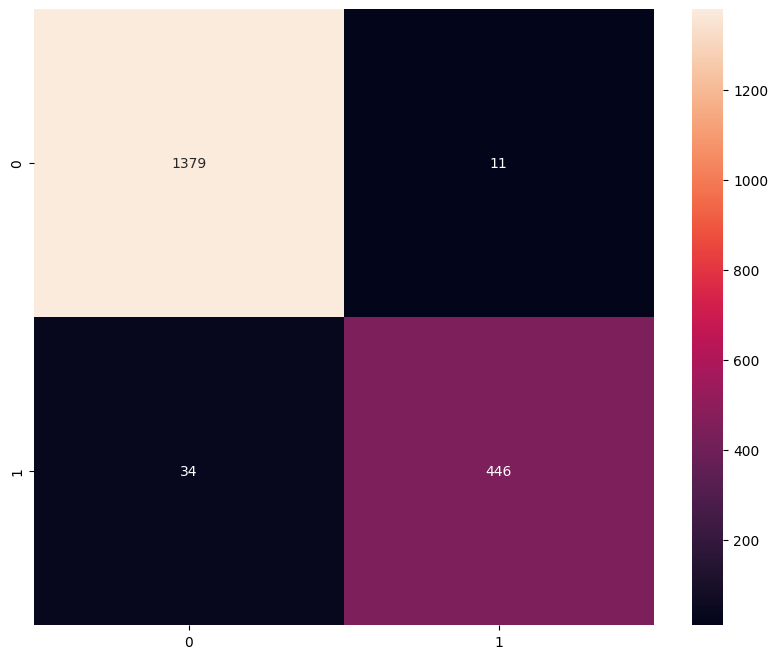

In [100]:
# run MNB + WordCountVectorizer
comp_esti(mnb, X_train_bow, X_test_bow, y_train_bow, y_test_bow)

MultinomialNB() Accuracy score:  0.9764705882352941

MultinomialNB() Classification report:
               precision    recall  f1-score   support

           0   0.980714  0.987770  0.984229      1390
           1   0.963830  0.943750  0.953684       480

    accuracy                       0.976471      1870
   macro avg   0.972272  0.965760  0.968957      1870
weighted avg   0.976380  0.976471  0.976389      1870



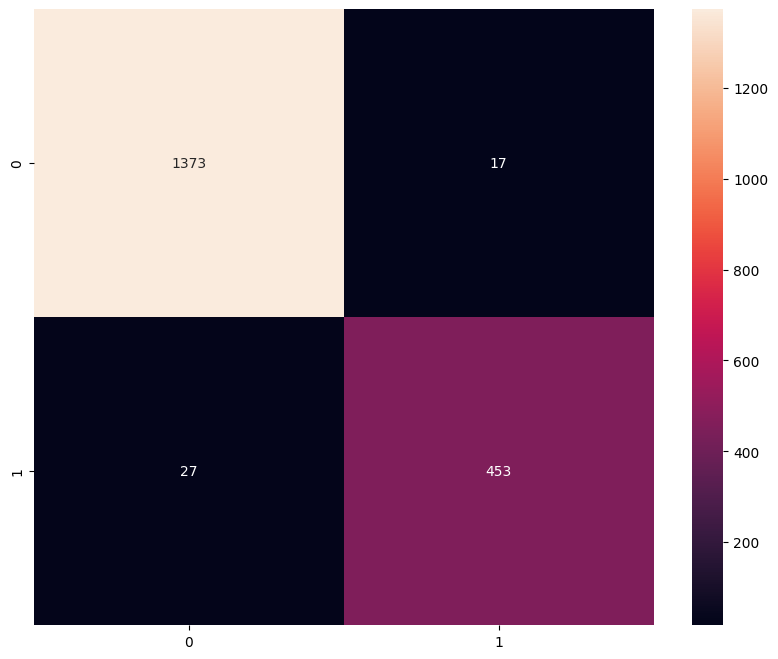

In [103]:
# run MNB + Tfidf-Vectorizer
comp_esti(mnb, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf)

In [93]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores,'Recall':recall_scores, 'F1-Score':f1_scores})
performance_df

,Algorithm,Accuracy,Precision,Recall,F1-Score
0,NB + BoW,0.975936,0.97593,0.929167,0.951974
1,NB + TF-IDF,0.976471,0.96383,0.943750,0.953684


In [94]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
performance_df1

,Algorithm,variable,value
0,NB + BoW,Accuracy,0.975936
1,NB + TF-IDF,Accuracy,0.976471
2,NB + BoW,Precision,0.975930
3,NB + TF-IDF,Precision,0.963830
4,NB + BoW,Recall,0.929167
5,NB + TF-IDF,Recall,0.943750
6,NB + BoW,F1-Score,0.951974
7,NB + TF-IDF,F1-Score,0.953684


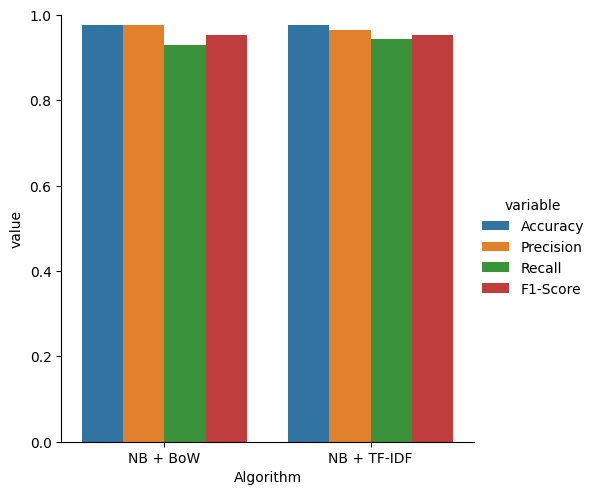

In [95]:
sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable', data=performance_df1, kind='bar', height=5)
plt.ylim(0.0,1.0)
plt.xticks(rotation='horizontal')
plt.show()

In [104]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))